In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
batch_size = 25
img_height, img_width = 256, 256
input_shape = (img_height, img_width, 3)


def create_data_sparse():
    # data_gen = ImageDataGenerator(horizontal_flip=True, rotation_range=20, width_shift_range=0.2,
    #                               height_shift_range=0.2, zoom_range=0.2)
    data_gen = ImageDataGenerator(rescale = 1/255., validation_split = 0.2)

    train_images = data_gen.flow_from_directory('Dataset/PandasBears/Train', 
                                                target_size=(img_height, img_width),
                                                class_mode='binary', 
                                                batch_size=500, 
                                                subset='training', 
                                                # color_mode='rgb'
                                                )
    
    
    test_images = data_gen.flow_from_directory('Dataset/PandasBears/Test', 
                                               target_size=(img_height, img_width),
                                               class_mode='binary', 
                                               batch_size=200, 
                                               shuffle=False, 
                                            #    color_mode='rgb'
                                               )

    return train_images, test_images

train_images, test_images = create_data_sparse()

labels = ['bear', 'panda']
# print(train_images)


Found 400 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [14]:
print(len(train_images[0][0]))

400


In [10]:
X_train = train_images[0][0]
y_train = train_images[0][1]

X_test = test_images[0][0]
y_test = test_images[0][1]
# print(X_train)

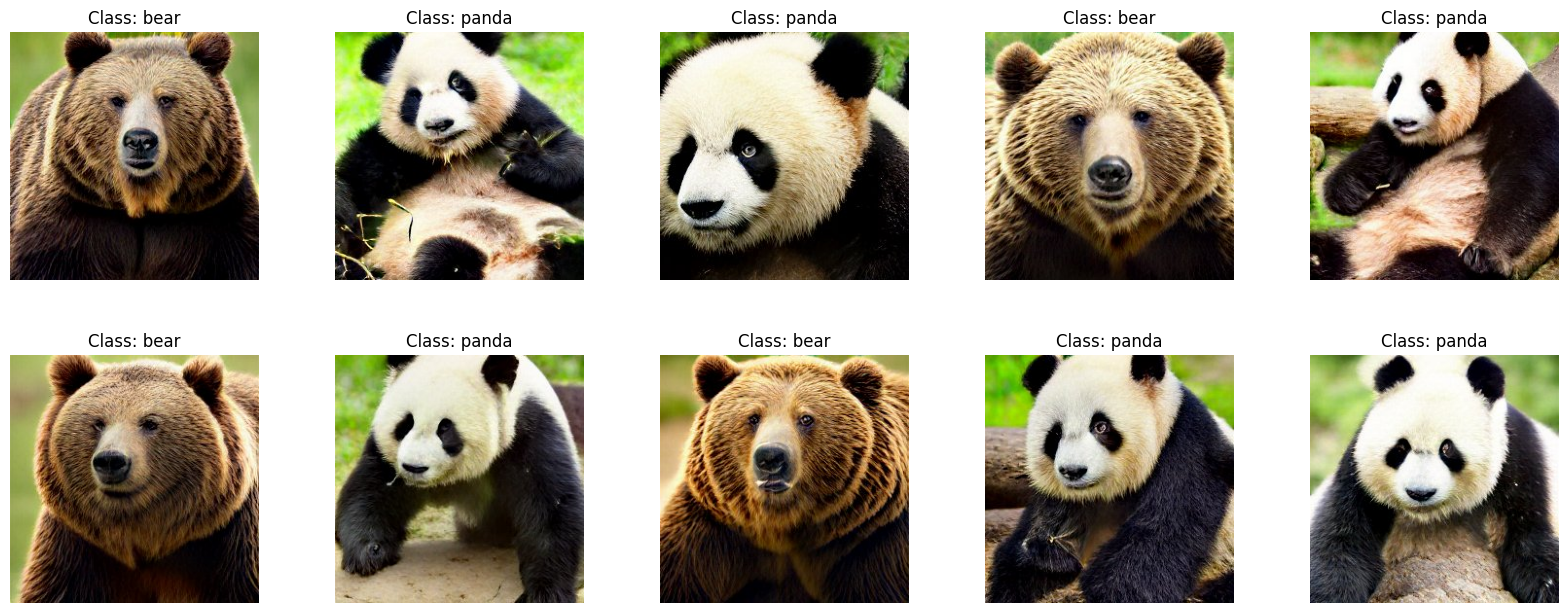

In [16]:


plt.figure(figsize = (20,20))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.subplots_adjust(hspace=0.3,wspace=0.3)
    plt.imshow(X_train[i])
    plt.title(f"Class: {labels[int(y_train[i])]}")
    plt.axis('off')


In [90]:
import numpy as np

class Pooling:
    def __init__(self,  filter_size, stride, mode):
        self.filter_size = filter_size
        self.stride = stride
        self.mode = mode

    def forward(self, input):
        input_size = input.shape
        output_size = (((input_size[0] - self.filter_size[0] ) // self.stride ) + 1, ((input_size[1] - self.filter_size[1]) // self.stride ) + 1)
        output = np.zeros((output_size[0], output_size[1],input_size[2]))
        for i in range(0,input_size[0] - self.filter_size[0] +1, self.stride):
            for j in range(0, input_size[1] - self.filter_size[1] +1 ,self.stride):
                for n in range(input_size[2]):
                    input_patch = input[i:i+self.filter_size[0], j:j+self.filter_size[1], n]
                    if self.mode == "max":
                        # Max pooling
                        output[i//self.stride][j//self.stride][n] = np.max(input_patch)
                    elif self.mode == "average":
                        # Average pooling
                        output[i//self.stride][j//self.stride][n] = np.mean(input_patch)
        self.output_size = output.shape

        return output
    
    def getModel(self):
        model = {
            "type": "max_pooling2d",
            "params": {}
        }
        return model
    
    def showModel(self):
        print(f"Pooling              {self.output_size}              0")
        print("________________________________________________________")


In [85]:
import numpy as np

class Convolution:
    
    # TODO: diferent width / height
    def __init__(self, input_size, padding_size, filter_size, num_filters, stride, bias):
        self.input_size = input_size
        self.padding_size = padding_size
        self.filter_size = filter_size

        self.num_filters = num_filters
        self.stride = stride
        # self.bias = bias

        self.output_size = (((input_size[0] - filter_size[0] + 2 * padding_size) // stride ) + 1, ((input_size[1] - filter_size[1] + 2 * padding_size) // stride ) + 1)
        # init random filter
        self.filter = [np.random.randn(self.filter_size[0], self.filter_size[1], input_size[2]) for _ in range(self.num_filters)]
        self.bias = np.zeros(self.num_filters)

    # include convolution and detector
    def forward(self, input):


        # Menambahkan padding jika diperlukan
        if self.padding_size > 0:
            padded_input = np.pad(input, ((self.padding_size, self.padding_size), (self.padding_size, self.padding_size), (0, 0)), mode='constant')
        else:
            padded_input = input

        # init input
        output = np.zeros((self.output_size[0], self.output_size[1], self.num_filters))

        for i in range(0,self.input_size[0] - self.filter_size[0] + (2 * self.padding_size) + 1, self.stride):
            for j in range(0, self.input_size[1] - self.filter_size[1] + (2 * self.padding_size) + 1,self.stride):
                for n in range(self.num_filters):
                    # Mengambil bagian input yang sesuai dengan ukuran filter
                    input_patch = padded_input[i:i+self.filter_size[0], j:j+self.filter_size[1]]
                    # Melakukan operasi konvolusi
                    output[i//self.stride][j//self.stride][n] = np.maximum(0, np.sum(input_patch * self.filter[n]) + self.bias[n])

        return output
    
    def getModel(self):
        filter_list = [filter_.tolist() for filter_ in self.filter]
        bias_list = self.bias.tolist()
        model = {
            "type": "conv2d",
            "params":{
                "kernel": filter_list ,
                "bias": bias_list
            }
        }

        return model
    
    def setFilter(self, filter):
        self.filter = filter

    def showModel(self):
        print(f"Convolution          {self.output_size}             {(self.num_filters * (self.filter_size[0] * self.filter_size[0] + 1))}")
        print("________________________________________________________")

In [8]:
import numpy as np
class Flatten:
    def __init__(self):
        pass

    def forward(self, input_data):
        # Mendapatkan ukuran input
        input_shape = input_data.shape

        # Melakukan flatten, mengubah tensor tiga dimensi menjadi tensor dua dimensi
        output_data = input_data.flatten()
        self.output_shape = output_data.shape
        return output_data
    
    def getModel(self):
        model = {
            "type": "flatten",
            "params": {}
        }
        return model
    
    def showModel(self, input =1):
        print(f"Flatten              {self.output_shape}                  0 ")
        print("________________________________________________________")

In [201]:
import numpy as np
class Dense:
    def __init__(self, num_units, activation_function, input_size = None):
        self.input_size = input_size
        self.num_units = num_units
        self.activation_function = activation_function

        # Initialize weights and bias with random values
        if (input_size != None):
            self.weights = np.random.randn(self.input_size, self.num_units)

        self.bias = np.zeros(num_units)

    def forward(self, input_data):

        if (self.input_size == None):
            self.input_size = input_data.shape[0]
            self.weights = np.random.randn(self.input_size, self.num_units)
        
        # Perform matrix multiplication (input_data * weights) and add bias
        pre_activation = np.dot(input_data, self.weights) + self.bias

        # Apply activation function based on the chosen mode
        if self.activation_function == "relu":
            output_data = self.relu(pre_activation)
        elif self.activation_function == "sigmoid":
            output_data = self.sigmoid(pre_activation)
        else:
            output_data =  pre_activation
    
        return output_data

    def relu(self, x):
        return np.maximum(0, x)

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    def getModel(self):
        weight_list = self.weights.tolist()
        bias_list = self.bias.tolist()
        model = {
            "type": "dense",
            "params":{
                "kernel": weight_list ,
                "bias": bias_list,
                "activation": self.activation_function
            }
        }

        return model
    
    def setWeights(self, weights):
        self.input_size = weights.shape[0]
        self.weights = weights

    def setBias(self, bias):
        self.bias = bias
        
    def showModel(self, input =1):
        print(f"Dense                ({self.num_units})                 {(input + 1) * self.num_units}")
        print("________________________________________________________")

In [10]:
import json
import numpy as np

class Model: 
    def __init__(self):
        self.layers =[]

    def train_network(self,train_data, label_data, batch_size, lr=0.01, epochs=200):
        batch_train = np.array_split(train_data,batch_size)
        batch_label = np.array_split(label_data, batch_size)
        for epoch in range(epochs):
            total_loss = 0.0
            correct_predictions = 0
            num = 0

            for i in range(len(batch_train)):
                # for j in range(len(batch_train[i])):
                for j in range(5):
                    input = batch_train[i][j]
                    for layer in self.layers:
                        output = layer.forward(input)
                        input = output
                    predictions = output[0]
                    if (predictions>0.5):
                        predict = 1
                    else :
                        predict = 0
                    num +=1
                    if predict == batch_label[i][j]:
                        correct_predictions += 1
            accuracy = (correct_predictions / num) * 100.0
            print(f"Epoch {epoch + 1}/{epochs} - Accuracy: {accuracy:.2f}%")    
                
        return 0
        
    def add(self,layer):
        self.layers.append(layer)

    def saveModel(self):
        save_model = []
        for layer in self.layers:
            out_model = layer.getModel()
            if out_model != '':
                save_model.append(out_model)
        file_name = 'model.json'

        # Open the file in write mode and write the save_model list to it as JSON
        with open(file_name, 'w') as json_file:
            json.dump(save_model, json_file)

    def showModel(self):
        print("Layer (type)         Output Shape             Param #")
        print("========================================================")
        for layer in self.layers:
            layer.showModel()

In [73]:
samples = next(train_images)
input_shape = samples[0][0].shape
conv = Convolution(input_size=input_shape, padding_size=1, filter_size=(3, 3), num_filters=2, stride=1, bias=0)
pool = Pooling(filter_size = (32,32), stride=32, mode='max')
flat = Flatten()
dense_layer_relu = Dense(num_units=7, activation_function="sigmoid")
dense_layer_sigmoid = Dense(num_units=1, activation_function="relu")
model = Model()
model.add(conv )
model.add(pool)
model.add(flat)
model.add(dense_layer_relu)
model.add(dense_layer_sigmoid)


In [74]:
model.train_network(train_data=X_train, label_data=y_train, batch_size=1, lr=0.01, epochs=1)

Epoch 1/1 - Accuracy: 80.00%


0

In [12]:
model.saveModel()

In [75]:
model.showModel()

Layer (type)         Output Shape             Param #
Convolution          (256, 256)         20
________________________________________________________
Pooling              (8, 8, 2)               
________________________________________________________
Flatten              (128,)              0 
________________________________________________________
Dense                (7)            14
________________________________________________________
Dense                (1)            2
________________________________________________________


In [86]:
import numpy as np
input = np.array([[[4],
                    [1],
                    [3],
                    [5],
                    [3]],

                    [[2],
                    [1],
                    [1],
                    [2],
                    [2]],

                    [[5],
                    [5],
                    [1],
                    [2],
                    [3]],

                    [[2],
                    [2],
                    [4],
                    [3],
                    [2]],

                    [[5],
                    [1],
                    [3],
                    [4],
                    [5]]])
input_shape = input.shape
conv2d =  Convolution(input_size=input_shape, padding_size=0, filter_size=(3, 3), num_filters=2, stride=1, bias=0)
# a = np.random.randn(3,3,1)
filter = np.array([
                [[[ 1],
                    [2],
                    [3]],

                    [[4],
                    [7],
                    [5]],

                    [[3],
                    [-32],
                    [25]]],

                [[[ 12],
                    [18],
                    [12]],

                    [[18],
                    [-74],
                    [45]],

                [[-92],
                    [45],
                    [-18]]]
                    ])

conv2d.setFilter(filter)
# print(conv2d.filter)


In [88]:
output_conv = conv2d.forward(input)
print(output_conv)

[[[  0.   0.]
  [ 76.   0.]
  [ 64.  66.]]

 [[109.   0.]
  [  0. 102.]
  [ 10.   0.]]

 [[118.   0.]
  [ 71.   0.]
  [ 67.   0.]]]


In [91]:
pool = Pooling(filter_size = (3,3), stride=1, mode='max')
output_pool=pool.forward(output_conv)
print(output_pool)

[[[118. 102.]]]


In [180]:
flat = Flatten()
flat_output = flat.forward(output_pool)
print(flat_output)

[118. 102.]


In [181]:
dense = Dense(num_units=2, activation_function="relu")
weight_dense = np.array([[1,2],[3,-4]])
bias = np.array([0,0])
dense.setWeights(weight_dense)
dense.setBias(bias)
dense_output = dense.forward(flat_output)
print(dense_output)

[424.   0.]


In [211]:
dense_layer_sigmoid = Dense(num_units=10, activation_function="sigmoid")
weight_dense_s = np.array([[0.09,0.08,0.07,0.06,0.05,0.04,0.03,0.04,0.05,0.01]
                            ,[0.02,0.03,0.03,0.02,0.01,0.02,0.07,0.08,0.05,0.01]]
                           )
bias_s = np.array([0,0,0,0,0,0,0,0,0,0])
dense_layer_sigmoid.setWeights(weight_dense_s)
dense_layer_sigmoid.setBias(bias_s)
dense_output_s = dense_layer_sigmoid.forward(dense_output)

print(dense_output_s)

[1.         1.         1.         1.         1.         0.99999996
 0.99999701 0.99999996 1.         0.98579704]
